# Import packages

In [1]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy import sparse
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, RobustScaler
from sklearn.metrics import silhouette_score


# Load data

In [2]:
file_path = '../processed_data/cleaned_data_final.csv'


In [3]:
df = pd.read_csv(file_path)

df.head()


,name,male,origin,isMarried,isNoble,popularity,isAlive,season,episode,deaths,episode_num
0,Viserys II Targaryen,1,House Targaryen,0,0,0.605351,0,8,The Bells,Lord Varys - Burned alive by Drogon with his f...,71
1,Walder Frey,1,House Frey,1,1,0.896321,0,6,The Winds of Winter,Lord Walder Frey - Throat slit by Arya Stark w...,60
2,Addison Hill,1,House Lannister,0,1,0.267559,1,0,NaN,NaN,0
3,Aemma Arryn,0,House Arryn,1,1,0.183946,0,5,The Gift,Maester Aemon Targaryen - Died of natural causes.,47
4,Sylva Santagar,0,House Martell,1,1,0.043478,1,0,NaN,NaN,0


In [4]:
df.drop(labels=['episode','deaths','name'],axis=1, inplace=True)


In [5]:
df.columns


Index(['male', 'origin', 'isMarried', 'isNoble', 'popularity', 'isAlive',
       'season', 'episode_num'],
      dtype='object')

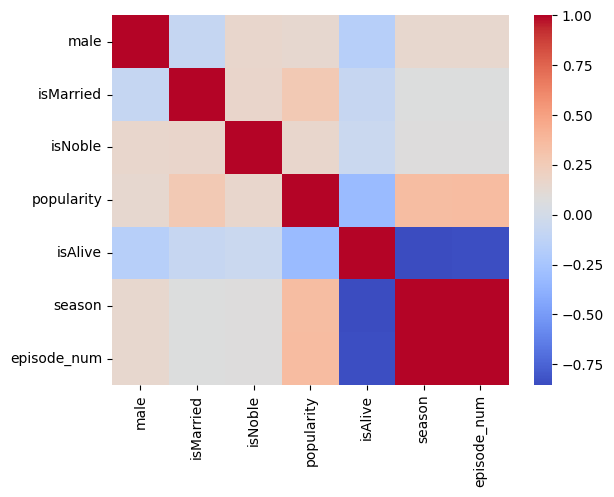

In [6]:
sns.heatmap(df.select_dtypes(exclude= ['object']).corr(), cmap='coolwarm');


# Encoding and Stadndarizing of features

In [ ]:
df.info()


In [ ]:
df.popularity.sort_values().value_counts(dropna=False,sort=True, ascending=True)


In [ ]:
df.popularity.hist();


In [ ]:
df.popularity.plot(kind='box');


In [ ]:
df.episode_num.hist();


In [ ]:
df.episode_num.plot(kind='box');


In [ ]:
df.season.hist();


In [ ]:
df.season.plot(kind='box');


In [ ]:
df.season.value_counts(dropna=False, normalize=True)


In [ ]:
df.isna().sum()


## Chosen preprocessing of feautures:


|     | Column       | Preprocessing| Dtype    | 
| --- | ------------ | ------------- | ------- |
| 0   |  male        | none          | int64   |
| 1   |  origin      | one-hot enc   | object  | 
| 2   |  isMarried   | none          | int64   |
| 3   |  isNoble     | none          | int64   | 
| 4   |  popularity  | MinMax Scaler | float64 |
| 5   |  isAlive     | none          | int64   |
| 6   |  season      | MinMax Scaler | int64   |
| 7   |  episode_num | MinMax Scaler | int64   |

In [7]:
# Features that do not need transformation
no_transformation_features = ['male', 'isMarried','isNoble','isAlive']


In [8]:
# Categorical features --> OneHotEncoder
X_cat = df.select_dtypes(include = ['object']).columns.tolist()


In [9]:
# Ordinal features --> MinMax Scaler

X_ord = [col for col in df.columns if col not in no_transformation_features and col not in X_cat]
X_ord


['popularity', 'season', 'episode_num']

In [10]:
# Impute then scale numerical values:
num_transformer = Pipeline(steps=[
    ('MinMax_scaler', MinMaxScaler())
])

# Encode categorical values
cat_transformer = Pipeline(steps=[
    ('OHE', OneHotEncoder(handle_unknown='ignore'))

])

# Parallelize "num_transformer" and "cat_transfomer"
preproc_baseline = ColumnTransformer(
    transformers = [
        ('num_transformer', num_transformer, X_ord),
        ('cat_transformer', cat_transformer, X_cat),
        ('passthrough', 'passthrough', no_transformation_features)
    ]
)


In [11]:
preproc_baseline


ColumnTransformer(transformers=[('num_transformer',
                                 Pipeline(steps=[('MinMax_scaler',
                                                  MinMaxScaler())]),
                                 ['popularity', 'season', 'episode_num']),
                                ('cat_transformer',
                                 Pipeline(steps=[('OHE',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['origin']),
                                ('passthrough', 'passthrough',
                                 ['male', 'isMarried', 'isNoble', 'isAlive'])])

In [12]:
preproc_baseline.fit(df)
preproc_baseline.transform(df)

#Or just:
#preproc_baseline.fit_transform(df)


<1949x27 sparse matrix of type '<class 'numpy.float64'>'
	with 8701 stored elements in Compressed Sparse Row format>

In [13]:
shape_preproc_baseline = pd.DataFrame(preproc_baseline.transform(df)).shape


In [14]:
shape_preproc_baseline, df.shape


((1949, 1), (1949, 8))

# Apply K-means

In [15]:
n_clusters=5
random_state=42


## Creating the pipeline

In [16]:
kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init='auto')


In [17]:
pipe_baseline = Pipeline([
    ('preproc_baseline', preproc_baseline),
    ('kmeans', kmeans)
])


## Iterating and Evaluating Clusters:

### Silhoutte score

In [18]:
silhouette_scores = []
range_n_clusters = range(2, 200)


In [19]:
# Now in your loop
for n_cluster in range_n_clusters:
    # Update the number of clusters
    pipe_baseline.set_params(kmeans__n_clusters=n_cluster)

    # Fit and transform the pipeline
    cluster_labels = pipe_baseline.fit_predict(df)

    # Calculate the silhouette score
    silhouette_avg = silhouette_score(pipe_baseline.named_steps['preproc_baseline'].transform(df), cluster_labels)
    silhouette_scores.append(silhouette_avg)


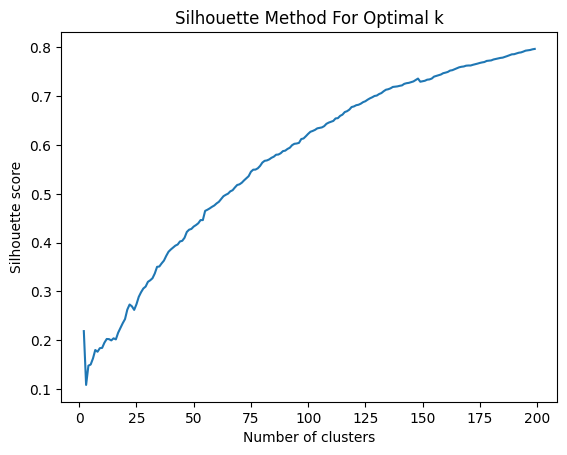

In [20]:
# Plotting the silhouette scores
plt.plot(range_n_clusters, silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method For Optimal k')
plt.show();


### Elbow method

In [21]:
# Empty list to store the inertia for each k
inertias = []

for n_cluster in range_n_clusters:
    # Update the number of clusters in the pipeline's kmeans
    pipe_baseline.set_params(kmeans__n_clusters=n_cluster)

    # Fit the pipeline to the data
    pipe_baseline.fit(df)

    # Append the inertia to the list of inertias
    inertias.append(pipe_baseline.named_steps['kmeans'].inertia_)


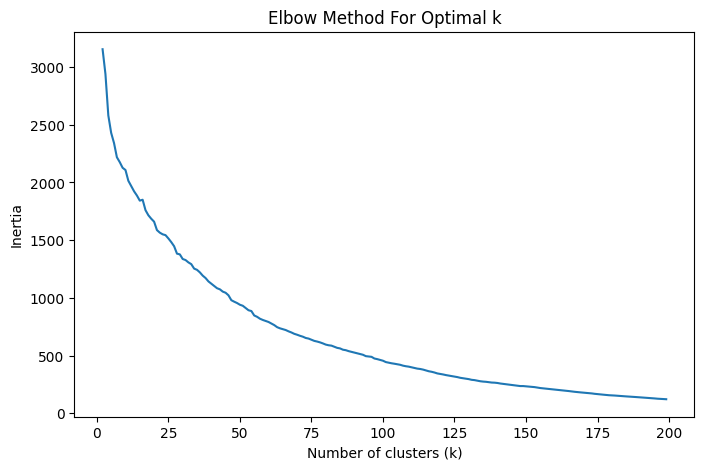

In [22]:
# Plot the Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, inertias)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show();


### Dendogram

In [23]:
# Step 1: Transform the data using the preprocessing pipeline
preprocessed_data = preproc_baseline.fit_transform(df)

# Step 2: Convert to a dense array if it's a sparse matrix
if sparse.issparse(preprocessed_data):  # Check if the matrix is a sparse matrix
    preprocessed_data = preprocessed_data.todense()  # Convert to dense
## Step 2: Convert to a dense array if it's a sparse matrix
#if isinstance(preprocessed_data, sparse.csr.csr_matrix):
#    preprocessed_data = preprocessed_data.todense()


#### Ward's method

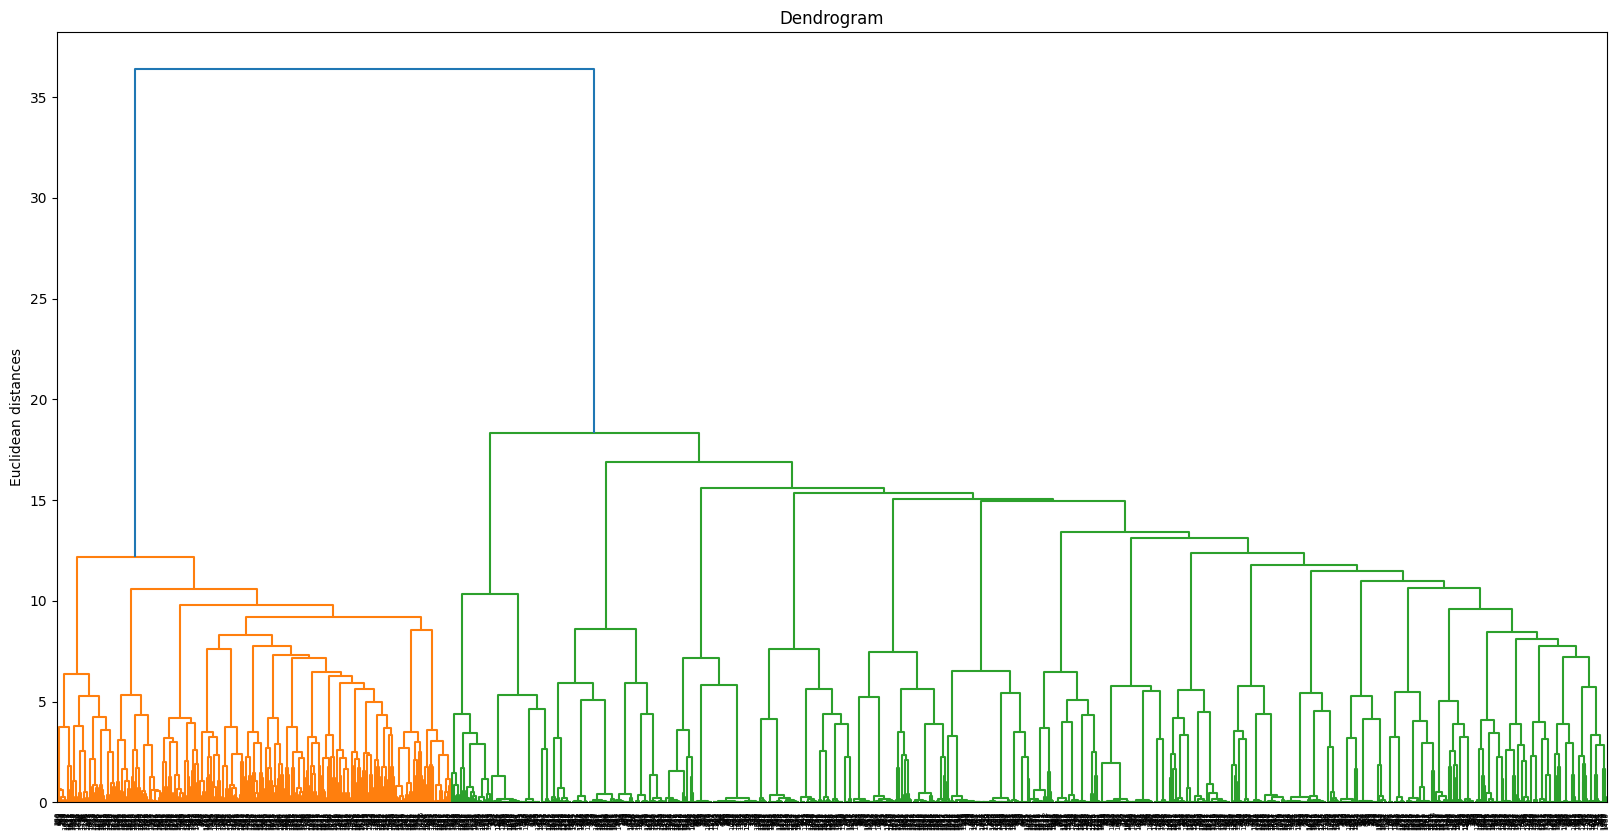

In [24]:
# Step 3: Compute the linkage matrix using the Ward's method
Z = linkage(preprocessed_data, method='ward')

# Step 4: Plot the dendrogram
plt.figure(figsize=(20, 10))
dendrogram(Z, color_threshold=None)
plt.title('Dendrogram')
plt.ylabel('Euclidean distances')
plt.show();


#### Other methods... ['single', 'complete','centroid','average' ]

In [25]:
methods = ['single', 'complete','centroid','average' ]


In [ ]:
#for method in methods:
#    Z = linkage(preprocessed_data, method=method)
#
#    plt.figure(figsize=(20, 10))
#    dendrogram(Z, color_threshold=None)
#    plt.title(f'Dendrogram {method} method')
#    plt.ylabel('Euclidean distances')
#    plt.show();


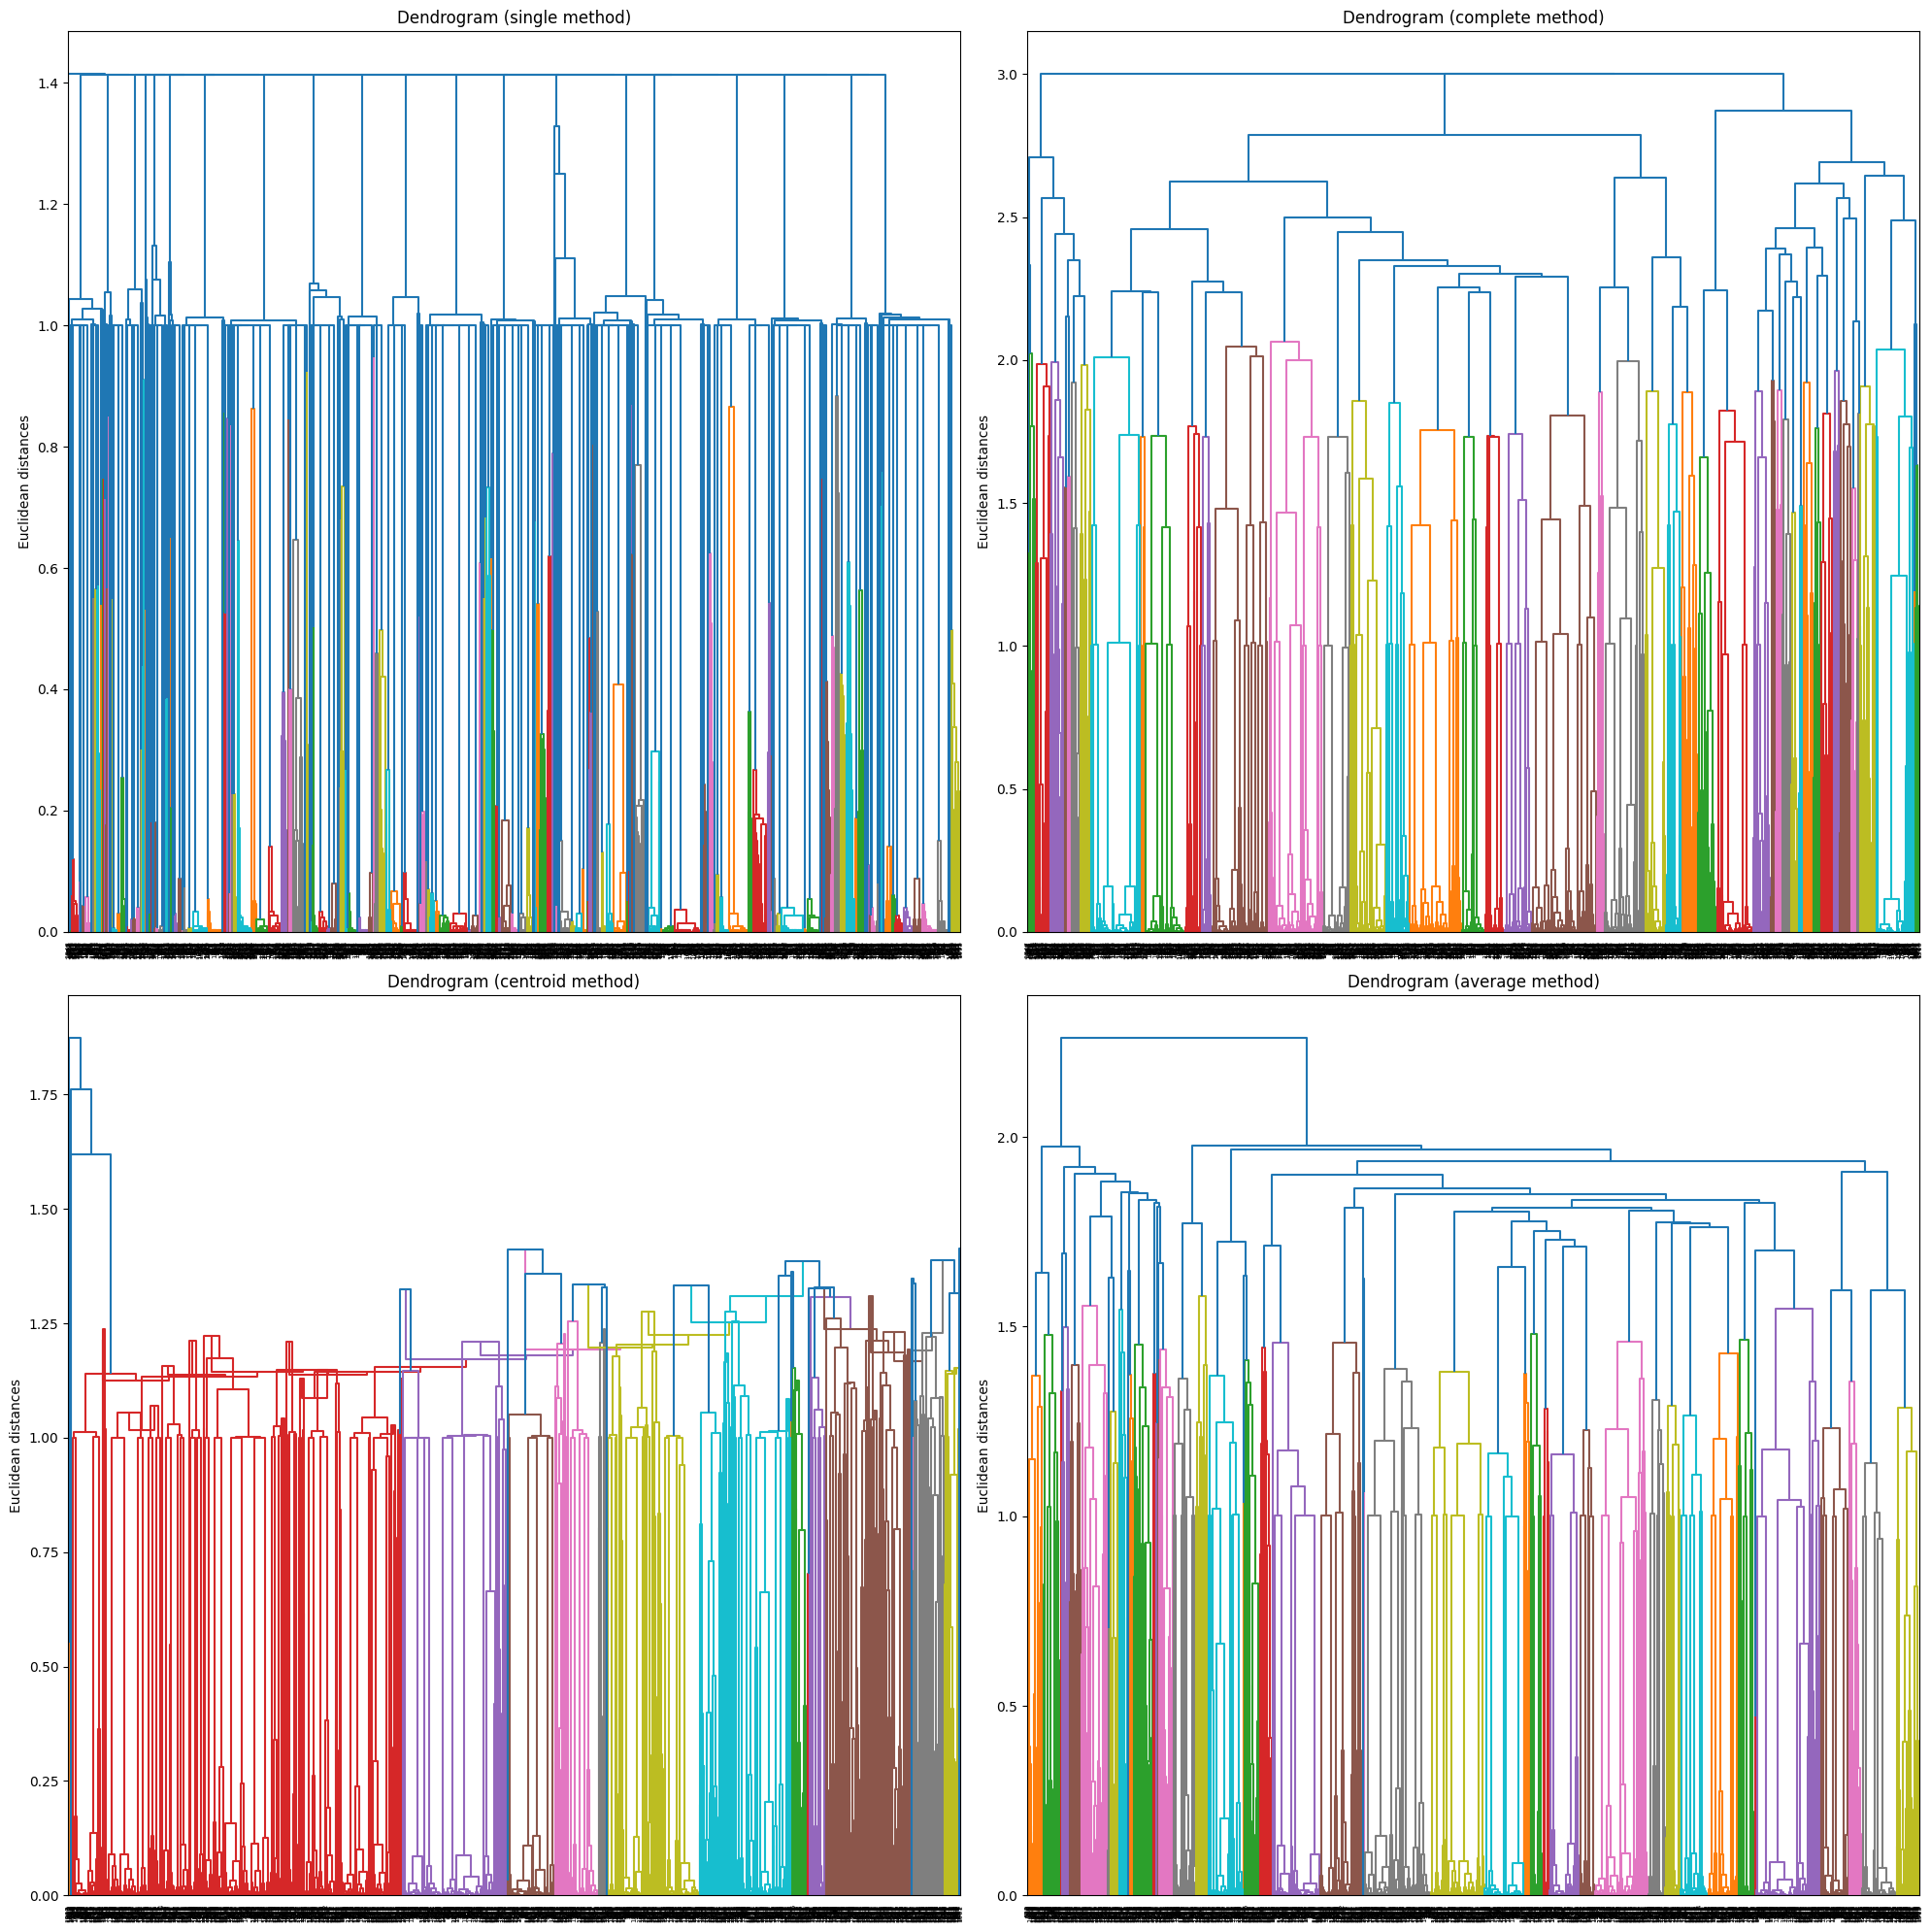

In [26]:
# Create a figure and specify its size
plt.figure(figsize=(20, 20))

# Loop through the methods, creating a subplot for each
for i, method in enumerate(methods, 1):  # Start enumeration at 1
    # Compute the linkage matrix
    Z = linkage(preprocessed_data, method=method)

    # Create a subplot in the specified position
    plt.subplot(2, 2, i)

    # Generate the dendrogram for this method
    dendrogram(Z, color_threshold=None)

    # Add title and labels
    plt.title(f'Dendrogram ({method} method)')
    plt.ylabel('Euclidean distances')

# Adjust layout for better spacing between plots
plt.tight_layout()
plt.show();


Do kmeans again without season or episode_num... or without both, try robust scaler first.

In [ ]:
sns.heatmap(df.select_dtypes(exclude= ['object']).corr(), cmap='coolwarm');


## Using Robust Scaler instead of minmax

In [27]:
df.columns


Index(['male', 'origin', 'isMarried', 'isNoble', 'popularity', 'isAlive',
       'season', 'episode_num'],
      dtype='object')

In [28]:
X_ord


['popularity', 'season', 'episode_num']

In [29]:
# Impute then scale numerical values:
num_transformer = Pipeline(steps=[
    ('Robust_scaler', RobustScaler())
])

# Encode categorical values
cat_transformer = Pipeline(steps=[
    ('OHE', OneHotEncoder(handle_unknown='ignore'))

])

# Parallelize "num_transformer" and "cat_transfomer"
preproc_baseline_rb = ColumnTransformer(
    transformers = [
        ('num_transformer', num_transformer, X_ord),
        ('cat_transformer', cat_transformer, X_cat),
        ('passthrough', 'passthrough', no_transformation_features)
    ]
)


In [30]:
preproc_baseline_rb


ColumnTransformer(transformers=[('num_transformer',
                                 Pipeline(steps=[('Robust_scaler',
                                                  RobustScaler())]),
                                 ['popularity', 'season', 'episode_num']),
                                ('cat_transformer',
                                 Pipeline(steps=[('OHE',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['origin']),
                                ('passthrough', 'passthrough',
                                 ['male', 'isMarried', 'isNoble', 'isAlive'])])

In [31]:
preproc_baseline_rb.fit_transform(df)


<1949x27 sparse matrix of type '<class 'numpy.float64'>'
	with 8744 stored elements in Compressed Sparse Row format>

In [32]:
shape_preproc_baseline = pd.DataFrame(preproc_baseline.transform(df)).shape
shape_preproc_baseline, df.shape


((1949, 1), (1949, 8))

### Apply kmeans

In [33]:
n_clusters=5
random_state=42


In [34]:
kmeans_rb = KMeans(n_clusters=n_clusters, random_state=random_state, n_init='auto')


In [36]:
kmeans_rb


KMeans(n_clusters=5, n_init='auto', random_state=42)

In [35]:
pipe_baseline_rb = Pipeline([
    ('preproc_baseline', preproc_baseline_rb),
    ('kmeans', kmeans_rb)
])


In [37]:
pipe_baseline_rb


Pipeline(steps=[('preproc_baseline',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  Pipeline(steps=[('Robust_scaler',
                                                                   RobustScaler())]),
                                                  ['popularity', 'season',
                                                   'episode_num']),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('OHE',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['origin']),
                                                 ('passthrough', 'passthrough',
                                                  ['male', 'isMarried',
                                                   'isNoble', 'isAlive'])])),
                ('kmeans',
                 KMeans(n_clusters=5, n_init='auto', random_state=42))])

#### Iterating and evaluating clusters 

##### Silhoutte score

In [40]:
silhouette_scores = []
range_n_clusters = range(2, 200)


In [41]:
# Now in your loop
for n_clusters in range_n_clusters:
    # Update the number of clusters
    pipe_baseline_rb.set_params(kmeans__n_clusters=n_clusters)

    # Fit and transform the pipeline
    cluster_labels = pipe_baseline_rb.fit_predict(df)

    # Calculate the silhouette score
    silhouette_avg = silhouette_score(pipe_baseline_rb.named_steps['preproc_baseline'].transform(df), cluster_labels)
    silhouette_scores.append(silhouette_avg)


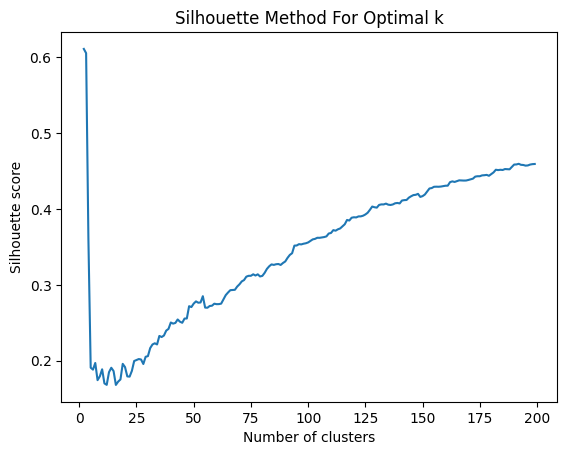

In [42]:
# Plotting the silhouette scores
plt.plot(range_n_clusters, silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method For Optimal k')
plt.show();


##### Elbow method

In [43]:
# Empty list to store the inertia for each k
inertias = []

for n_clusters in range_n_clusters:
    # Update the number of clusters in the pipeline's kmeans
    pipe_baseline_rb.set_params(kmeans__n_clusters=n_clusters)

    # Fit the pipeline to the data
    pipe_baseline_rb.fit(df)

    # Append the inertia to the list of inertias
    inertias.append(pipe_baseline_rb.named_steps['kmeans'].inertia_)


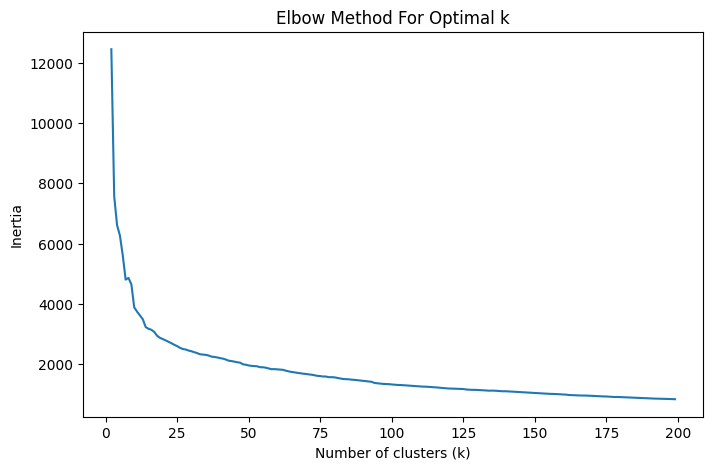

In [44]:
# Plot the Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, inertias)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show();


##### Dendogram

In [45]:
# Step 1: Transform the data using the preprocessing pipeline
preprocessed_data = preproc_baseline_rb.fit_transform(df)

# Step 2: Convert to a dense array if it's a sparse matrix
if sparse.issparse(preprocessed_data):  # Check if the matrix is a sparse matrix
    preprocessed_data = preprocessed_data.todense()  # Convert to dense
## Step 2: Convert to a dense array if it's a sparse matrix
#if isinstance(preprocessed_data, sparse.csr.csr_matrix):
#    preprocessed_data = preprocessed_data.todense()


##### Wards's method

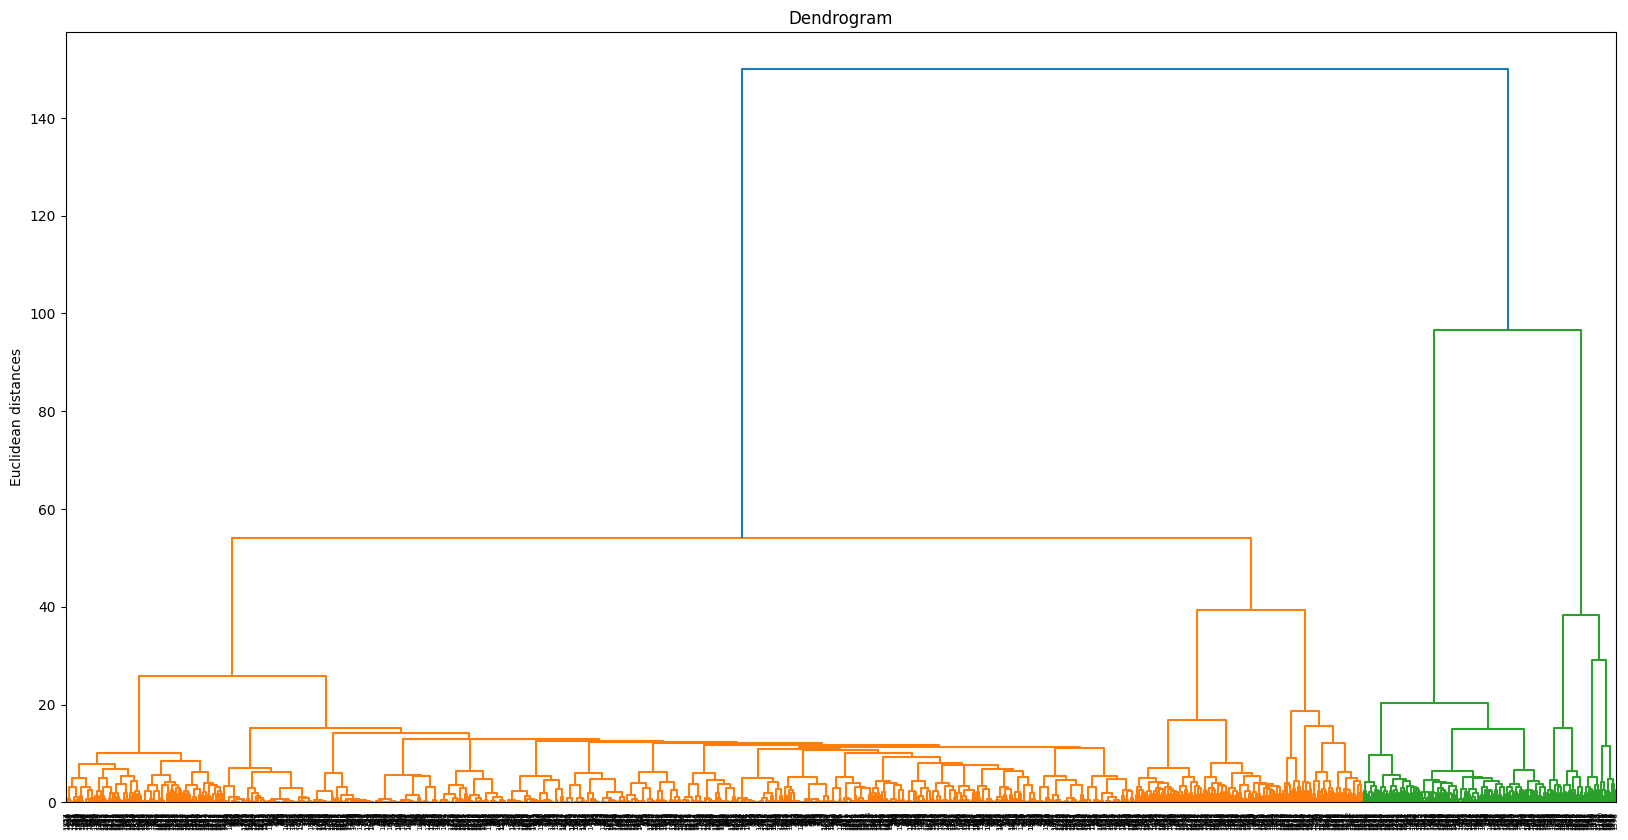

In [46]:
# Step 3: Compute the linkage matrix using the Ward's method
Z = linkage(preprocessed_data, method='ward')

# Step 4: Plot the dendrogram
plt.figure(figsize=(20, 10))
dendrogram(Z, color_threshold=None)
plt.title('Dendrogram')
plt.ylabel('Euclidean distances')
plt.show();


#### Other methods... ['single', 'complete','centroid','average' ]

In [47]:
methods = ['single', 'complete','centroid','average' ]


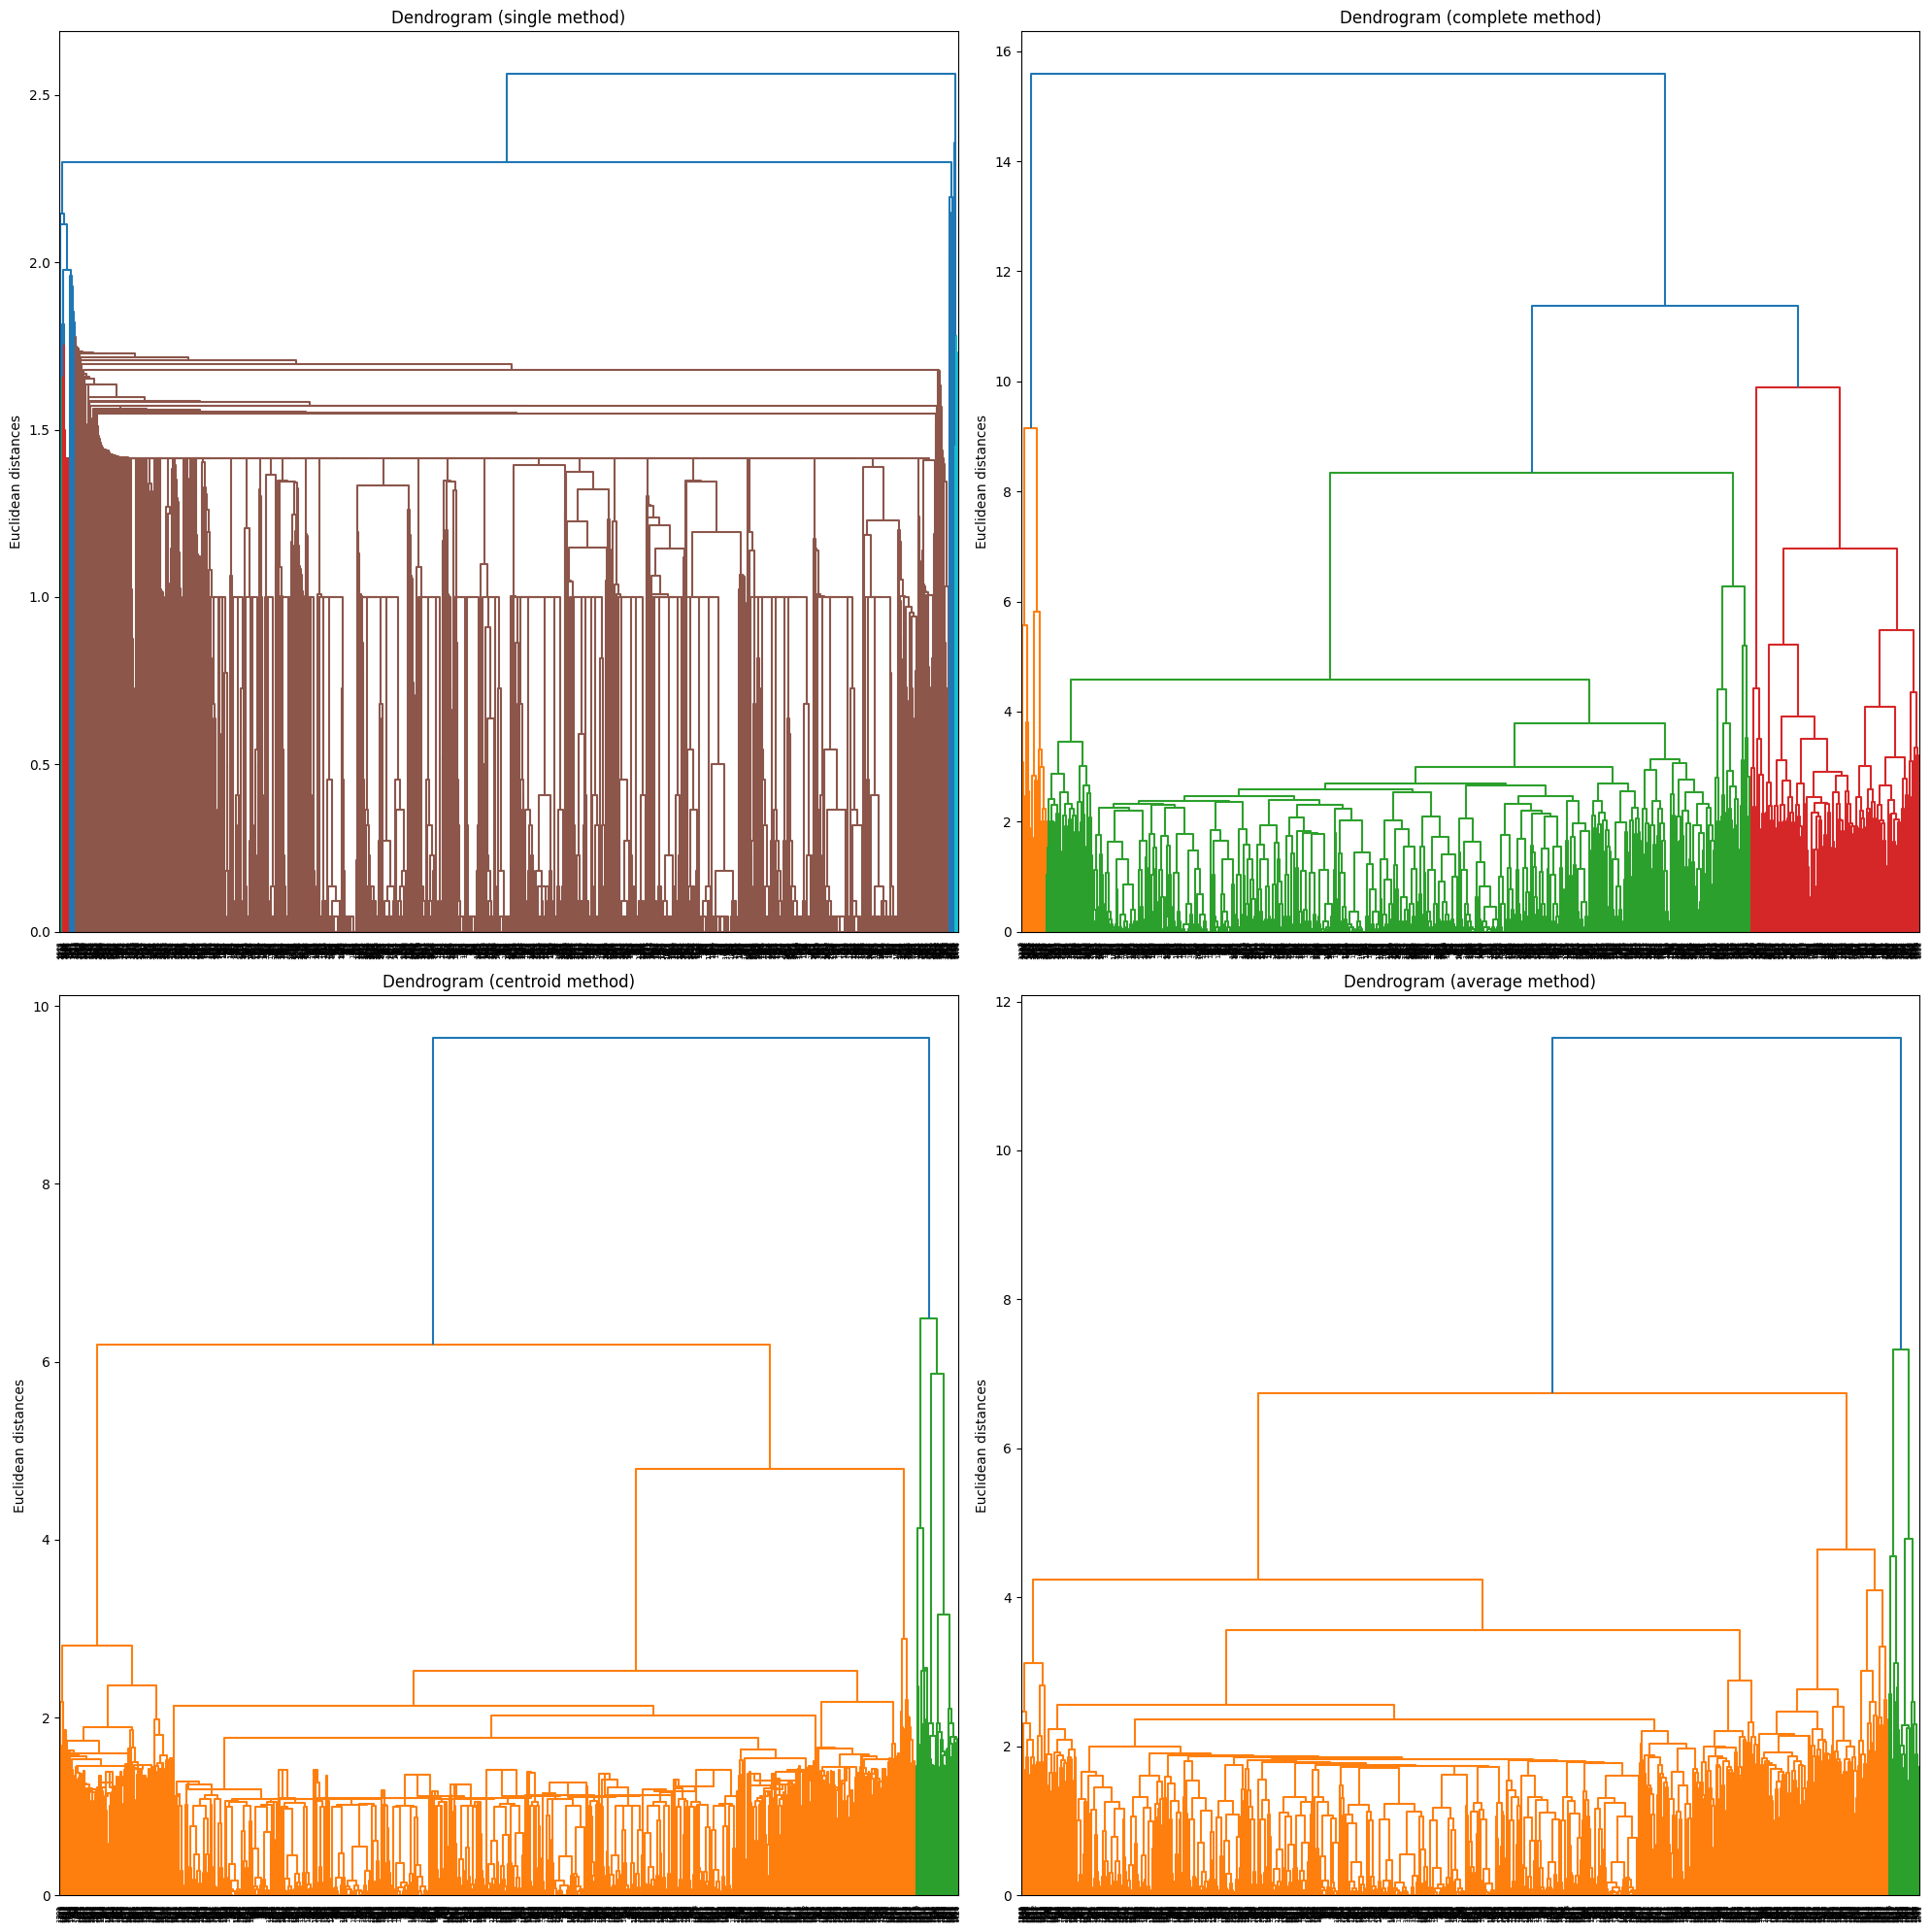

In [48]:
# Create a figure and specify its size
plt.figure(figsize=(20, 20))

# Loop through the methods, creating a subplot for each
for i, method in enumerate(methods, 1):  # Start enumeration at 1
    # Compute the linkage matrix
    Z = linkage(preprocessed_data, method=method)

    # Create a subplot in the specified position
    plt.subplot(2, 2, i)

    # Generate the dendrogram for this method
    dendrogram(Z, color_threshold=None)

    # Add title and labels
    plt.title(f'Dendrogram ({method} method)')
    plt.ylabel('Euclidean distances')

# Adjust layout for better spacing between plots
plt.tight_layout()
plt.show();


(1948, 4)

# Clustering without Season and episode_num

In [70]:
df = pd.read_csv(file_path)

df.head()


,name,male,origin,isMarried,isNoble,popularity,isAlive,season,episode,deaths,episode_num
0,Viserys II Targaryen,1,House Targaryen,0,0,0.605351,0,8,The Bells,Lord Varys - Burned alive by Drogon with his f...,71
1,Walder Frey,1,House Frey,1,1,0.896321,0,6,The Winds of Winter,Lord Walder Frey - Throat slit by Arya Stark w...,60
2,Addison Hill,1,House Lannister,0,1,0.267559,1,0,NaN,NaN,0
3,Aemma Arryn,0,House Arryn,1,1,0.183946,0,5,The Gift,Maester Aemon Targaryen - Died of natural causes.,47
4,Sylva Santagar,0,House Martell,1,1,0.043478,1,0,NaN,NaN,0


In [52]:
df.columns


Index(['name', 'male', 'origin', 'isMarried', 'isNoble', 'popularity',
       'isAlive', 'season', 'episode', 'deaths', 'episode_num'],
      dtype='object')

In [71]:
df.drop(labels=['episode','deaths','name','episode_num','season'],axis=1, inplace=True)


In [ ]:
sns.heatmap(df.select_dtypes(exclude= ['object']).corr(), cmap='coolwarm');


In [ ]:
df.info()


Let's try MinMax Scaler first

In [54]:
# Categorical features --> OneHotEncoder
X_cat = df.select_dtypes(include = ['object']).columns.tolist()
# Features that do not need transformation
no_transformation_features = ['male', 'isMarried','isNoble','isAlive']
# Ordinal features --> MinMax Scaler
X_ord = [col for col in df.columns if col not in no_transformation_features and col not in X_cat]

print(f'X_cat: {X_cat}, X_ord:{X_ord}, features without transformation: {no_transformation_features}')


X_cat: ['origin'], X_ord:['popularity'], features without transformation: ['male', 'isMarried', 'isNoble', 'isAlive']


In [55]:
# Impute then scale numerical values:
num_transformer = Pipeline(steps=[
    ('MinMax_scaler', MinMaxScaler())
])

# Encode categorical values
cat_transformer = Pipeline(steps=[
    ('OHE', OneHotEncoder(handle_unknown='ignore'))

])

# Parallelize "num_transformer" and "cat_transfomer"
preproc_baseline = ColumnTransformer(
    transformers = [
        ('num_transformer', num_transformer, X_ord),
        ('cat_transformer', cat_transformer, X_cat),
        ('passthrough', 'passthrough', no_transformation_features)
    ]
)


In [56]:
preproc_baseline


ColumnTransformer(transformers=[('num_transformer',
                                 Pipeline(steps=[('MinMax_scaler',
                                                  MinMaxScaler())]),
                                 ['popularity']),
                                ('cat_transformer',
                                 Pipeline(steps=[('OHE',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['origin']),
                                ('passthrough', 'passthrough',
                                 ['male', 'isMarried', 'isNoble', 'isAlive'])])

In [57]:
preproc_baseline.fit_transform(df)


<1949x25 sparse matrix of type '<class 'numpy.float64'>'
	with 7589 stored elements in Compressed Sparse Row format>

In [58]:
shape_preproc_baseline = pd.DataFrame(preproc_baseline.transform(df)).shape
shape_preproc_baseline, df.shape


((1949, 1), (1949, 6))

### Applying K-meansº

In [59]:
n_clusters=5
random_state=42


In [60]:
kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init='auto')


In [61]:
pipe_baseline = Pipeline([
    ('preproc_baseline', preproc_baseline),
    ('kmeans', kmeans)
])


### Iterating and evaluating clusters

In [65]:
silhouette_scores = []
range_n_clusters = range(2, 200)

# Now in your loop
for n_cluster in range_n_clusters:
    # Update the number of clusters
    pipe_baseline.set_params(kmeans__n_clusters=n_cluster)

    # Fit and transform the pipeline
    cluster_labels = pipe_baseline.fit_predict(df)

    # Calculate the silhouette score
    silhouette_avg = silhouette_score(pipe_baseline.named_steps['preproc_baseline'].transform(df), cluster_labels)
    silhouette_scores.append(silhouette_avg)


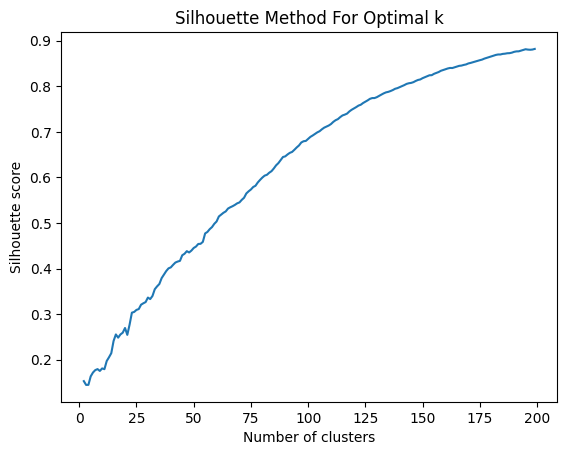

In [66]:
# Plotting the silhouette scores
plt.plot(range_n_clusters, silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method For Optimal k')
plt.show();


In [68]:
# Empty list to store the inertia for each k
inertias = []

for n_clusters in range_n_clusters:
    # Update the number of clusters in the pipeline's kmeans
    pipe_baseline.set_params(kmeans__n_clusters=n_clusters)

    # Fit the pipeline to the data
    pipe_baseline.fit(df)

    # Append the inertia to the list of inertias
    inertias.append(pipe_baseline.named_steps['kmeans'].inertia_)


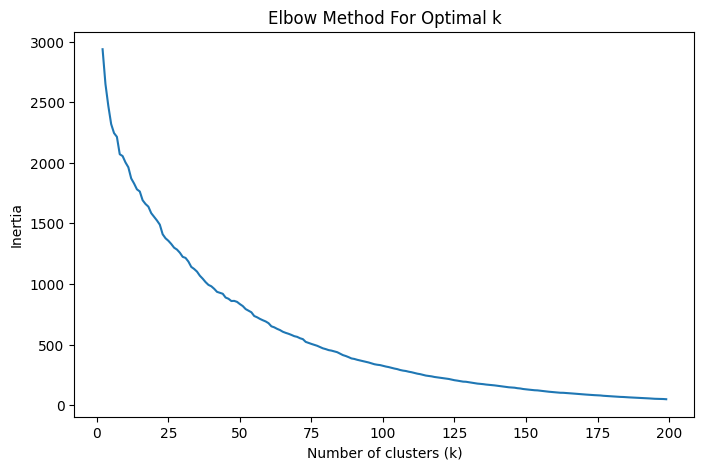

In [69]:
# Plot the Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, inertias)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show();


## Using Robust Scaler instead of minmax, without season and episode_num

In [72]:
df.columns


Index(['male', 'origin', 'isMarried', 'isNoble', 'popularity', 'isAlive'], dtype='object')

In [73]:
X_ord


['popularity']

In [74]:
# Impute then scale numerical values:
num_transformer = Pipeline(steps=[
    ('Robust_scaler', RobustScaler())
])

# Encode categorical values
cat_transformer = Pipeline(steps=[
    ('OHE', OneHotEncoder(handle_unknown='ignore'))

])

# Parallelize "num_transformer" and "cat_transfomer"
preproc_baseline_rb = ColumnTransformer(
    transformers = [
        ('num_transformer', num_transformer, X_ord),
        ('cat_transformer', cat_transformer, X_cat),
        ('passthrough', 'passthrough', no_transformation_features)
    ]
)


In [75]:
preproc_baseline_rb


ColumnTransformer(transformers=[('num_transformer',
                                 Pipeline(steps=[('Robust_scaler',
                                                  RobustScaler())]),
                                 ['popularity']),
                                ('cat_transformer',
                                 Pipeline(steps=[('OHE',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['origin']),
                                ('passthrough', 'passthrough',
                                 ['male', 'isMarried', 'isNoble', 'isAlive'])])

In [76]:
preproc_baseline_rb.fit_transform(df)


<1949x25 sparse matrix of type '<class 'numpy.float64'>'
	with 7632 stored elements in Compressed Sparse Row format>

In [77]:
shape_preproc_baseline = pd.DataFrame(preproc_baseline.transform(df)).shape
shape_preproc_baseline, df.shape


((1949, 1), (1949, 6))

### Apply kmeans

In [78]:
n_clusters=5
random_state=42


In [79]:
kmeans_rb = KMeans(n_clusters=n_clusters, random_state=random_state, n_init='auto')


In [80]:
kmeans_rb


KMeans(n_clusters=5, n_init='auto', random_state=42)

In [81]:
pipe_baseline_rb = Pipeline([
    ('preproc_baseline', preproc_baseline_rb),
    ('kmeans', kmeans_rb)
])


In [82]:
pipe_baseline_rb


Pipeline(steps=[('preproc_baseline',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  Pipeline(steps=[('Robust_scaler',
                                                                   RobustScaler())]),
                                                  ['popularity']),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('OHE',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['origin']),
                                                 ('passthrough', 'passthrough',
                                                  ['male', 'isMarried',
                                                   'isNoble', 'isAlive'])])),
                ('kmeans',
                 KMeans(n_clusters=5, n_init='auto', random_state=42))])

#### Iterating and evaluating clusters 

##### Silhoutte score

In [83]:
silhouette_scores = []
range_n_clusters = range(2, 200)


In [84]:
# Now in your loop
for n_clusters in range_n_clusters:
    # Update the number of clusters
    pipe_baseline_rb.set_params(kmeans__n_clusters=n_clusters)

    # Fit and transform the pipeline
    cluster_labels = pipe_baseline_rb.fit_predict(df)

    # Calculate the silhouette score
    silhouette_avg = silhouette_score(pipe_baseline_rb.named_steps['preproc_baseline'].transform(df), cluster_labels)
    silhouette_scores.append(silhouette_avg)


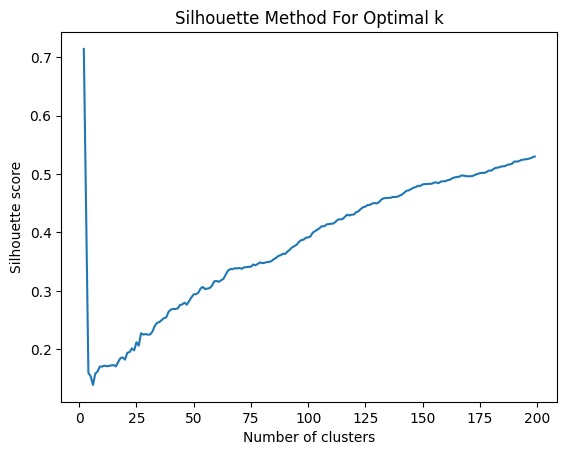

In [86]:
# Plotting the silhouette scores
plt.plot(range_n_clusters, silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method For Optimal k')
plt.show();


##### Elbow method

In [87]:
# Empty list to store the inertia for each k
inertias = []

for n_clusters in range_n_clusters:
    # Update the number of clusters in the pipeline's kmeans
    pipe_baseline_rb.set_params(kmeans__n_clusters=n_clusters)

    # Fit the pipeline to the data
    pipe_baseline_rb.fit(df)

    # Append the inertia to the list of inertias
    inertias.append(pipe_baseline_rb.named_steps['kmeans'].inertia_)


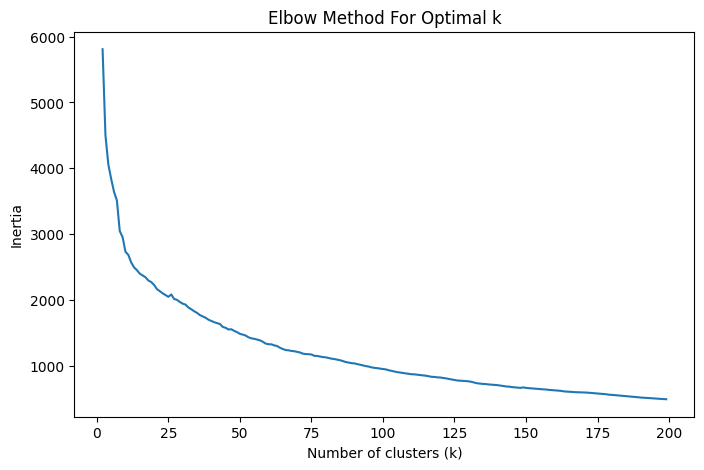

In [88]:
# Plot the Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, inertias)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show();


##### Dendogram

In [89]:
# Step 1: Transform the data using the preprocessing pipeline
preprocessed_data = preproc_baseline_rb.fit_transform(df)

# Step 2: Convert to a dense array if it's a sparse matrix
if sparse.issparse(preprocessed_data):  # Check if the matrix is a sparse matrix
    preprocessed_data = preprocessed_data.todense()  # Convert to dense
## Step 2: Convert to a dense array if it's a sparse matrix
#if isinstance(preprocessed_data, sparse.csr.csr_matrix):
#    preprocessed_data = preprocessed_data.todense()


##### Wards's method

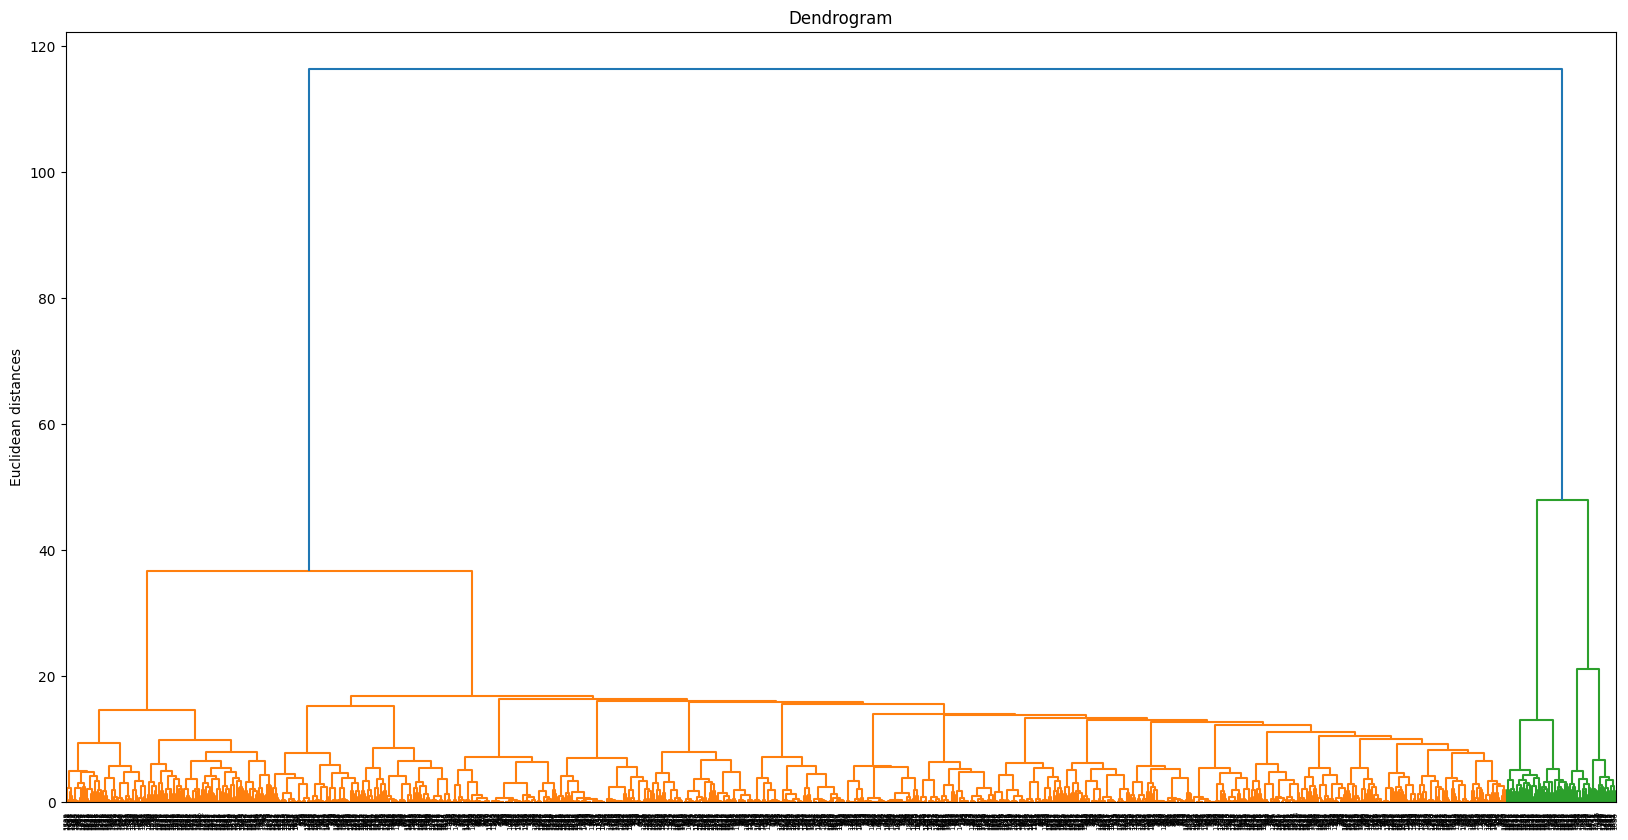

In [90]:
# Step 3: Compute the linkage matrix using the Ward's method
Z = linkage(preprocessed_data, method='ward')

# Step 4: Plot the dendrogram
plt.figure(figsize=(20, 10))
dendrogram(Z, color_threshold=None)
plt.title('Dendrogram')
plt.ylabel('Euclidean distances')
plt.show();


#### Other methods... ['single', 'complete','centroid','average' ]

In [91]:
methods = ['single', 'complete','centroid','average' ]


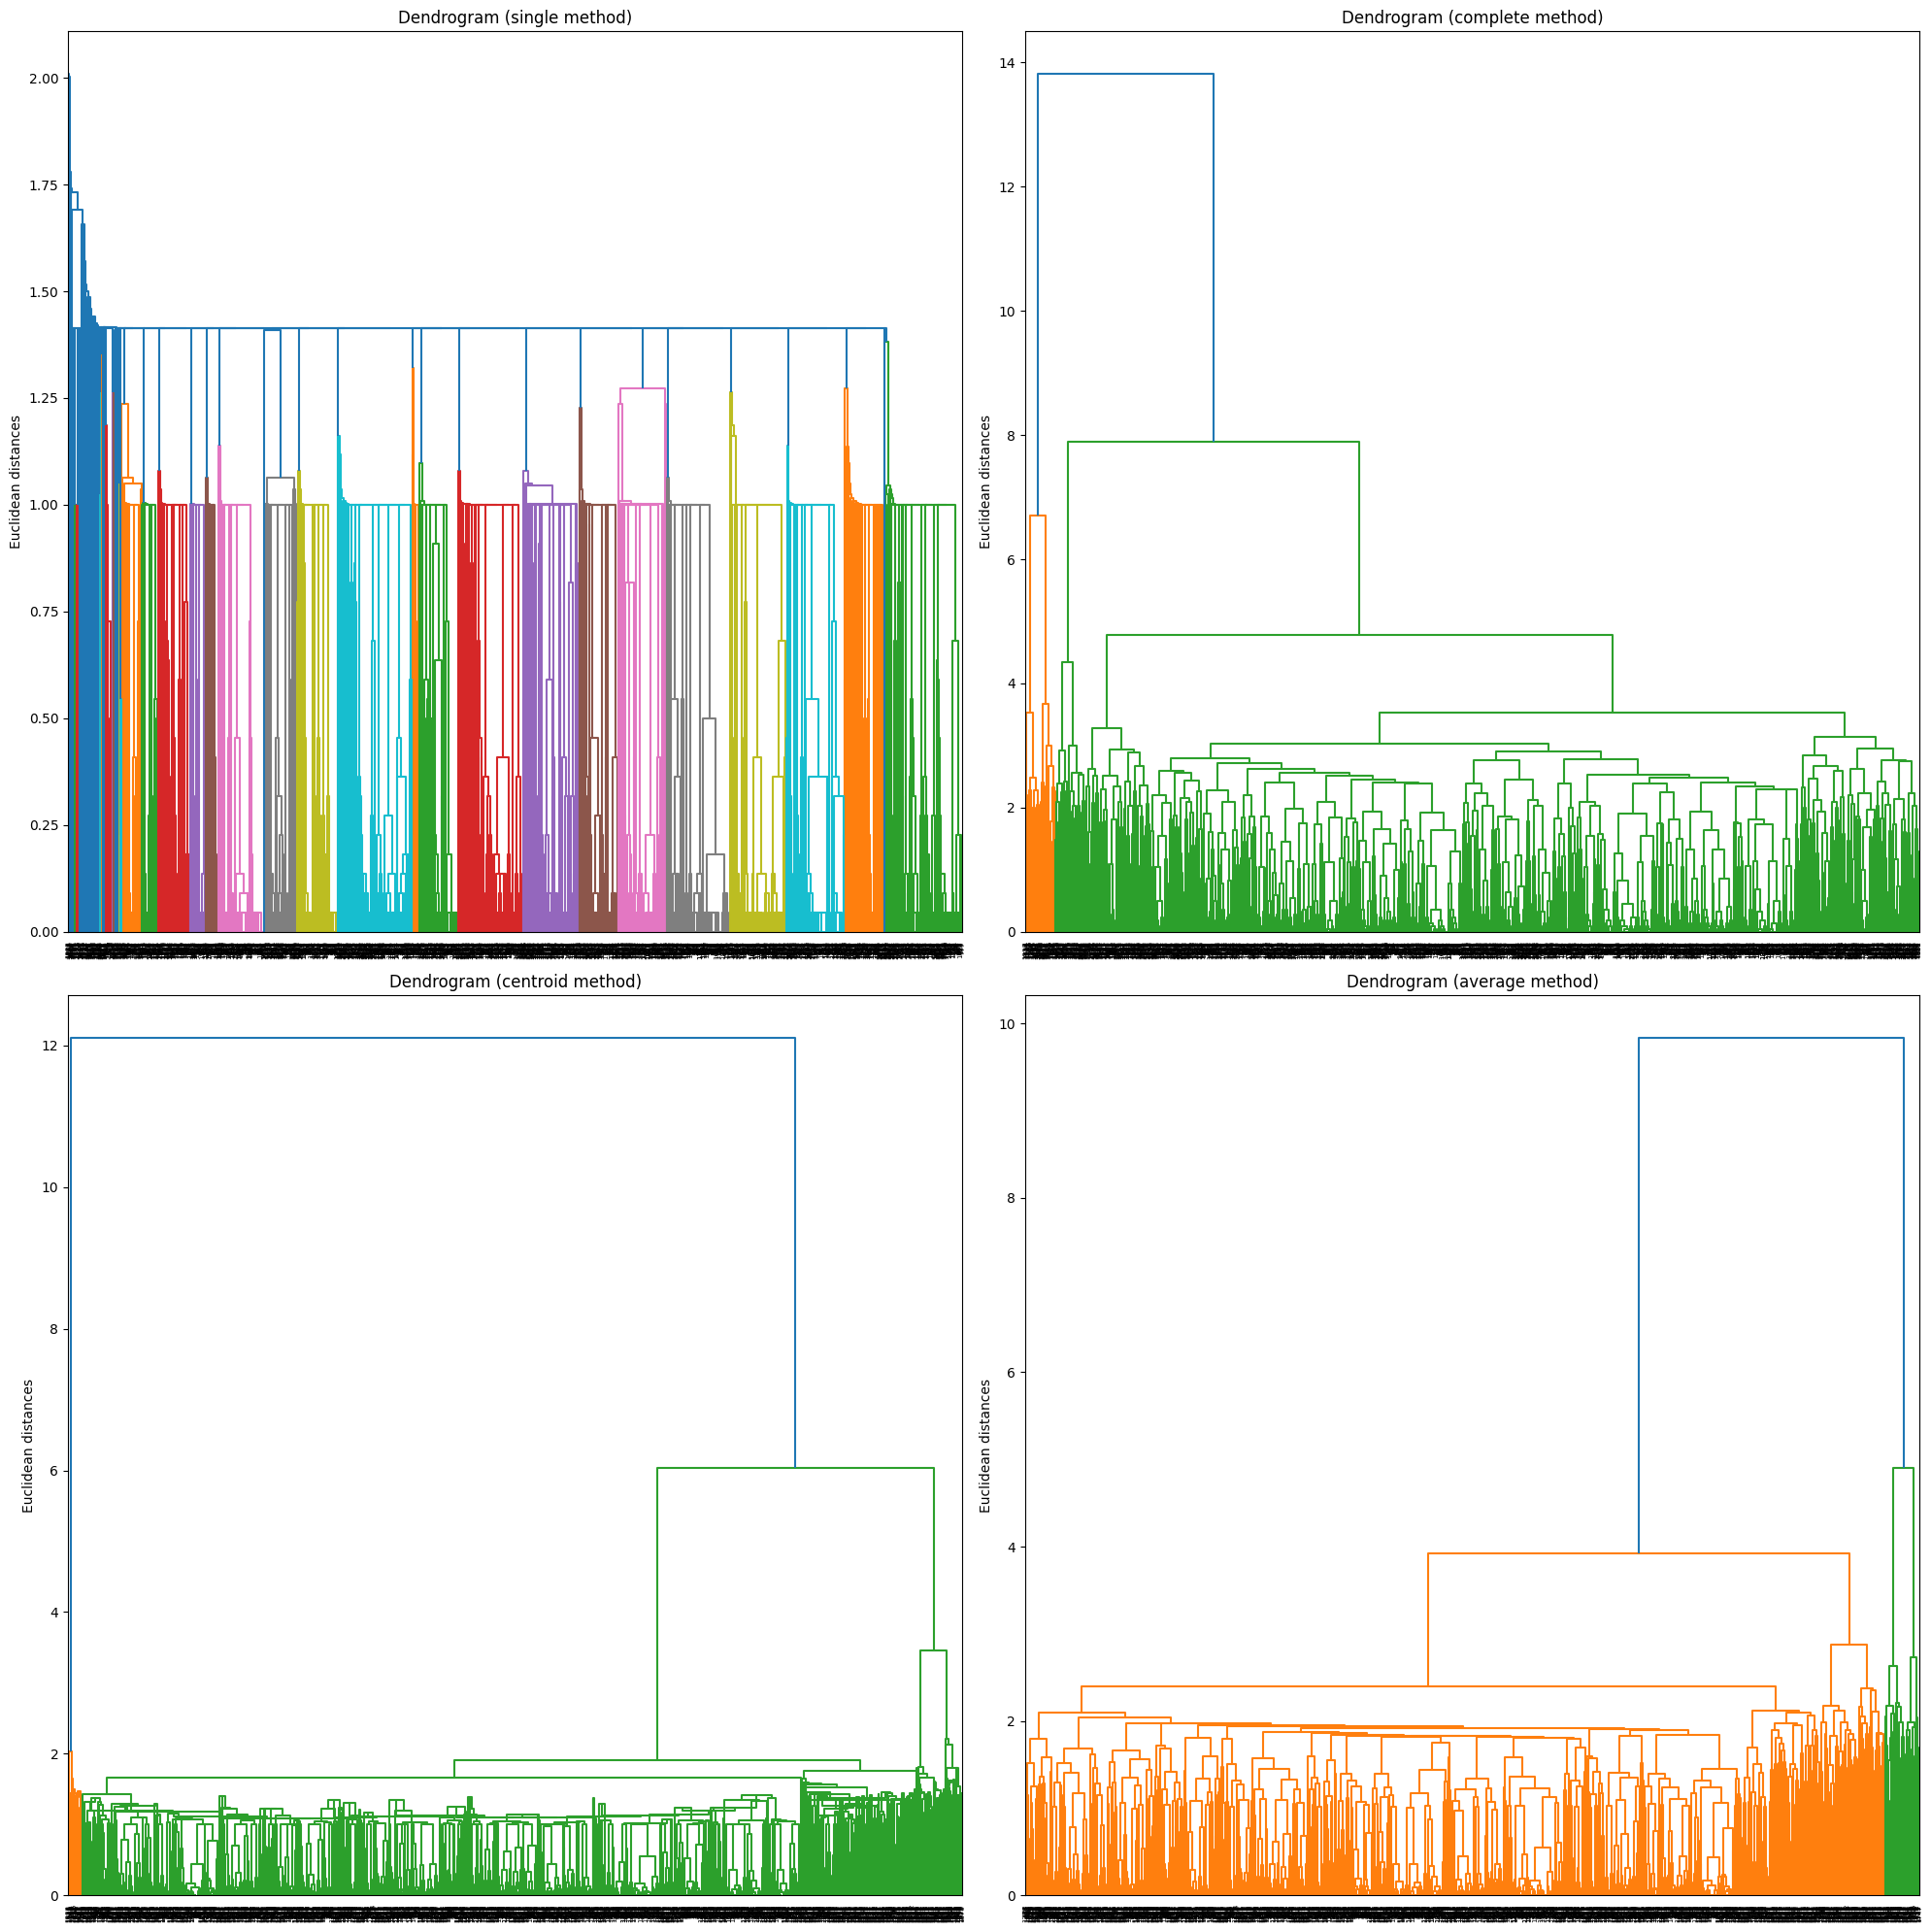

In [92]:
# Create a figure and specify its size
plt.figure(figsize=(20, 20))

# Loop through the methods, creating a subplot for each
for i, method in enumerate(methods, 1):  # Start enumeration at 1
    # Compute the linkage matrix
    Z = linkage(preprocessed_data, method=method)

    # Create a subplot in the specified position
    plt.subplot(2, 2, i)

    # Generate the dendrogram for this method
    dendrogram(Z, color_threshold=None)

    # Add title and labels
    plt.title(f'Dendrogram ({method} method)')
    plt.ylabel('Euclidean distances')

# Adjust layout for better spacing between plots
plt.tight_layout()
plt.show();
